In [ ]:
pd.set_option('display.float_format', '{:.15f}'.format)


 No                Pc                Pm  Iter_Berhenti            BBCA(%)           BBNI(%)            BBRI(%)            BMRI(%)           Fitness
  1 0.500000000000000 0.010000000000000           2000 71.198163580923506 1.407623641207820 11.707769467530674 15.686443310337999 0.000656725927946
  2 0.500000000000000 0.020000000000000           1533 73.076701873806797 1.097982388090199 12.669452553220248 13.155863184882739 0.000654956932028
  3 0.500000000000000 0.030000000000000           1601 72.628752206320328 0.013430340891774 12.788131026649149 14.569686426138739 0.000658270310521
  4 0.500000000000000 0.040000000000000           1566 70.948013724038759 0.346055296569254 11.961616780509026 16.744314198882957 0.000659292973773
  5 0.500000000000000 0.050000000000000            438 68.959293013382734 0.567658419156449 11.354564792720840 19.118483774739968 0.000658272606671
  6 0.500000000000000 0.060000000000000            488 71.436479416752931 0.496688186490535 12.088518306660504 1

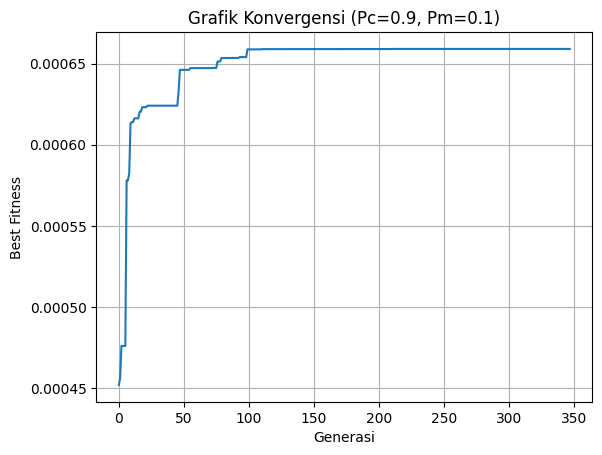

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

n_saham   = 4
pop_size  = 20
n_gen     = 2000
sigma_max = 1.2
patience  = 100

expected_return = np.array([0.0004, -0.0005, -0.0009, 0.0001])
cov_matrix = np.array([
    [1.97952,  0.942937, 0.257327, 1.005141],
    [0.942937, 3.520242, 0.120948, 2.361856],
    [0.257327, 0.120948, 3.289248, 0.082475],
    [1.005141, 2.361856, 0.082475, 3.681383]
])


def fitness_function(individu):
    # Pastikan total weight = 1 (Normalisasi)
    total_w = np.sum(individu)
    if total_w == 0: return 1e-8, individu
    w = individu / total_w

    port_return = np.dot(w, expected_return)
    port_var    = np.dot(w.T, np.dot(cov_matrix, w))
    port_risk   = np.sqrt(port_var)

    offset = 0.0006
    if port_risk <= sigma_max:
        fitness = (port_return + offset) / port_risk
    else:
        # Penalti berat jika melanggar batas risiko
        fitness = 1e-8

    return fitness, w


pc_list = [0.5, 0.6, 0.7, 0.8, 0.9] # Disederhanakan untuk contoh
pm_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

hasil_tabel = []
no = 1

for pc in pc_list:
    for pm in pm_list:
        # Inisialisasi Populasi
        populasi = np.random.rand(pop_size, n_saham)

        best_fitness = -np.inf
        best_weight  = None
        counter_stop = 0
        history_fitness = []

        for gen in range(n_gen):
            # EVALUASI
            evals = [fitness_function(ind) for ind in populasi]
            fitness_vals = np.array([e[0] for e in evals])

            # Elitisme
            idx_best_current = np.argmax(fitness_vals)
            elite_individual = populasi[idx_best_current].copy()

            if fitness_vals[idx_best_current] > best_fitness:
                best_fitness = fitness_vals[idx_best_current]
                best_weight  = evals[idx_best_current][1]
                counter_stop = 0
            else:
                counter_stop += 1

            history_fitness.append(best_fitness)

            # Check Early Stopping
            if counter_stop >= patience:
                break

            # SELEKSI (Roulette Wheel)
            total_fit = np.sum(fitness_vals)
            prob = fitness_vals / total_fit if total_fit != 0 else np.ones(pop_size)/pop_size
            selected_indices = np.random.choice(pop_size, pop_size, p=prob)
            selected = populasi[selected_indices]

            # CROSSOVER
            new_pop = []
            for i in range(0, pop_size, 2):
                parent1 = selected[i].copy()
                parent2 = selected[i+1].copy()

                if np.random.rand() < pc:
                    # Two-point crossover
                    cut1, cut2 = sorted(np.random.choice(range(1, n_saham), 2, replace=False))
                    child1 = np.concatenate([parent1[:cut1], parent2[cut1:cut2], parent1[cut2:]])
                    child2 = np.concatenate([parent2[:cut1], parent1[cut1:cut2], parent2[cut2:]])
                    new_pop.extend([child1, child2])
                else:
                    new_pop.extend([parent1, parent2])

            populasi = np.array(new_pop)

            # MUTASI
            for i in range(pop_size):
                if np.random.rand() < pm:
                    mut_idx = np.random.randint(n_saham)
                    populasi[i][mut_idx] = np.random.rand()

                # Normalisasi
                if np.sum(populasi[i]) > 0:
                    populasi[i] = populasi[i] / np.sum(populasi[i])

            populasi[0] = elite_individual

        hasil_tabel.append([
            no, pc, pm, gen+1,
            best_weight[0]*100, best_weight[1]*100,
            best_weight[2]*100, best_weight[3]*100,
            best_fitness
        ])
        no += 1


df = pd.DataFrame(
    hasil_tabel,
    columns=["No", "Pc", "Pm", "Iter_Berhenti", "BBCA(%)", "BBNI(%)", "BBRI(%)", "BMRI(%)", "Fitness"]
)

print(df.to_string(index=False))


plt.plot(history_fitness)
plt.title(f'Grafik Konvergensi (Pc={pc}, Pm={pm})')
plt.xlabel('Generasi')
plt.ylabel('Best Fitness')
plt.grid(True)
plt.show()

In [ ]:
from google.colab import files

df.to_excel('hasil_eksperimen_ag.xlsx', index=False)

files.download('hasil_eksperimen_ag.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("\n" + "="*40)
print("     HASIL PORTOFOLIO OPTIMAL")
print("="*40)

# Daftar nama saham
nama_saham = ["BBCA", "BBNI", "BBRI", "BMRI"]

# Alokasi bobot per saham
for i in range(len(nama_saham)):
    print(f"{nama_saham[i]:<10}: {best_weight[i]*100:>8.2f} %")

print("-" * 40)

port_return = np.dot(best_weight, expected_return)
port_var    = np.dot(best_weight.T, np.dot(cov_matrix, best_weight))
port_risk   = np.sqrt(port_var)

print(f"{'Expected Return':<15}: {port_return:.6f}")
print(f"{'Risk (Sigma)':<15}: {port_risk:.6f}")
print(f"{'Fitness Value':<15}: {best_fitness:.6f}")
print("="*40)


     HASIL PORTOFOLIO OPTIMAL
BBCA      :    71.05 %
BBNI      :     0.45 %
BBRI      :    11.96 %
BMRI      :    16.54 %
----------------------------------------
Expected Return: 0.000191
Risk (Sigma)   : 1.199999
Fitness Value  : 0.000659



=== 5 KOMBINASI PARAMETER TERBAIK ===
 No                Pc                Pm  Iter_Berhenti           Fitness
 27 0.700000000000000 0.070000000000000           1107 0.000660092999017
 18 0.600000000000000 0.080000000000000           1718 0.000660088320973
 45 0.900000000000000 0.050000000000000           1114 0.000660043503076
 35 0.800000000000000 0.050000000000000           1247 0.000660030660938
 20 0.600000000000000 0.100000000000000            798 0.000659973985234


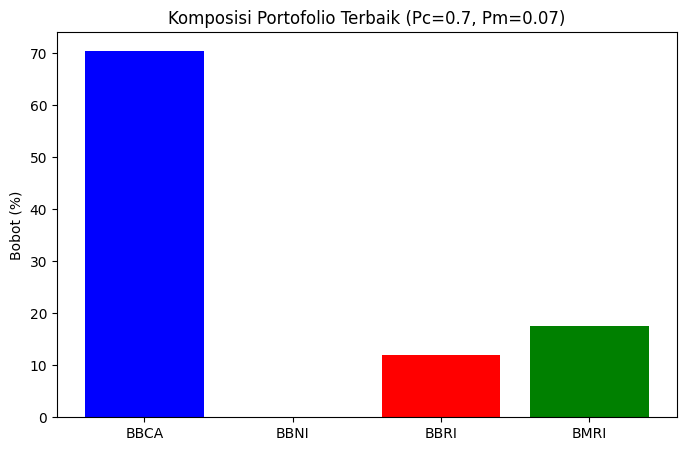

In [ ]:
df_top = df.sort_values(by='Fitness', ascending=False).head(5)

print("\n=== 5 KOMBINASI PARAMETER TERBAIK ===")
print(df_top[['No', 'Pc', 'Pm', 'Iter_Berhenti', 'Fitness']].to_string(index=False))

best_idx = df['Fitness'].idxmax()
weights = df.iloc[best_idx][['BBCA(%)', 'BBNI(%)', 'BBRI(%)', 'BMRI(%)']]
labels = ['BBCA', 'BBNI', 'BBRI', 'BMRI']

plt.figure(figsize=(8, 5))
plt.bar(labels, weights, color=['blue', 'orange', 'red', 'green'])
plt.title(f"Komposisi Portofolio Terbaik (Pc={df.iloc[best_idx]['Pc']}, Pm={df.iloc[best_idx]['Pm']})")
plt.ylabel("Bobot (%)")
plt.show()

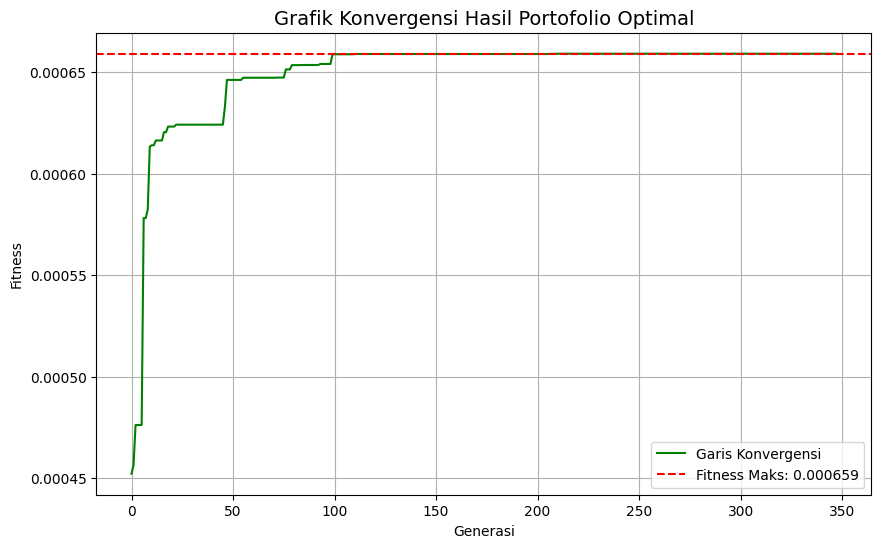

In [ ]:

best_overall_fitness = -float('inf')
best_history = []

if best_fitness > best_overall_fitness:
    best_overall_fitness = best_fitness
    best_history = history_fitness.copy()


plt.figure(figsize=(10, 6))
plt.plot(best_history, label='Garis Konvergensi', color='green')
plt.axhline(y=max(best_history), color='r', linestyle='--', label=f'Fitness Maks: {max(best_history):.6f}')

plt.title('Grafik Konvergensi Hasil Portofolio Optimal', fontsize=14)
plt.xlabel('Generasi')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()